In [1]:
from __future__ import division, print_function
# !conda install gensim -y
# !conda install nltk -y
import lib.xmlreader as xml
import lib.utils as ut
import numpy as np

import gensim.models.word2vec
import itertools
from collections import Counter
from nltk.tokenize import word_tokenize

import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import KFold
import collections
import numpy as np
import matplotlib.pyplot as plt
import operator
import os
%matplotlib inline

# New Getting Dataset

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import os
# sys.path.insert(0, os.getcwd()+'/fastai/')
sys.path.insert(0, os.getcwd()+'/ELMoForManyLangs/')
from fastai.text import *
import html
import json

import pandas as pd
import numpy as np
# from google_drive_downloader import GoogleDriveDownloader as gdd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix

np.random.seed(52)

In [3]:
YEAR='2017'
DATA_PATH=Path('./DATA/'+YEAR)
# DATA_PATH=Path('./data/election_tweets')

WIKILM_PATH=Path('./WIKI_LM/es/models')
PRE_FINETUNE_PATH=Path('./FINETUNE/'+YEAR)

TWEETSLM_PATH=Path('./TWEETS_LM/'+YEAR)
CLAS_PATH=Path('./TWEETS_CLAS/'+YEAR)

BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

In [4]:
def flattern(A):
    'Source: https://stackoverflow.com/a/17867797/7273299'
    
    'Flattens a list of lists and strings into a list.'
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flattern(i))
        else: rt.append(i)
    return rt

def isInt(v):
    'Source: https://stackoverflow.com/a/9859202/7273299'
    
    'Checks if a string is a number.'
    try:     i = int(v)
    except:  return False
    return True

def char_count(word, chars, lbound=2):
    char_count = [word.count(char) for char in chars]
    return all(i >= lbound for i in char_count)

def replace_lol(repl_str, texts):
    for string, chars in repl_str:
        texts = [[[string] if char_count(i, set(chars), 2) else i for i in text.split()] for text in texts]
        texts = np.array([flattern(text) for text in texts])
        texts = np.array([' '.join(text) for text in texts])
    return texts

import unicodedata

def strip_accents(text):
    """
    Strip accents from input String.

    :param text: The input string.
    :type text: String.

    :returns: The processed String.
    :rtype: String.
    """
    try:
        text = unicode(text, 'utf-8')
    except (TypeError, NameError): # unicode is a default on python 3 
        pass
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)

def preprocess_tweets(tweets):
    """
    twitter specific text processing and shuffle
    """
    # Remove \n
    tweets = np.array([str(i).replace('\n','. ') for i in tweets])
    tweets = np.array([str(i).replace('&lt;',' ') for i in tweets])
    tweets = np.array([str(i).replace('&gt;',' ') for i in tweets])
    tweets = np.array([str(i).replace('\xa0',' ') for i in tweets])
    
    # Remove accents
    tweets = np.array([strip_accents(i) for i in tweets])
    
    # Placeholders for hyperlinks and user references
    tweets = [['hyp_link' if i.startswith('http') 
               else 'hyp_link' if i.startswith('.http') 
               else 'user_ref' if i.startswith('@')
               else 'hash_tag' if i.startswith('#')
               else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([' '.join(i) for i in tweets])

    # Prefix for integers
    tweets = [[['int_string'] if isInt(i) 
               else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([flattern(tweet) for tweet in tweets])
    tweets = np.array([' '.join(i) for i in tweets])

    # Prefix for slang
    tweets = [[['que'] if i in ['q', 'k', 'qu', 'ke', 'qe'] 
               else ['por'] if i=='x' 
               else ['porque'] if i in ['xq', 'pq', 'porq'] 
               else ['de'] if i=='d' 
               else ['te'] if i=='t'
               else ['también'] if i=='tb'
               else ['Que'] if i in ['Q', 'K', 'Qu','Ke', 'Qe'] 
               else ['Por'] if i=='X'
               else ['Porque'] if i in ['Xq', 'Pq', 'Porq'] 
               else ['De'] if i=='D' 
               else ['Te'] if i=='T'
               else ['También'] if i=='Tb'
               else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([flattern(tweet) for tweet in tweets])
    tweets = np.array([' '.join(i) for i in tweets])

    # Lol type characters
    repl_str = [('risa_ja','ja'), ('risa_ji','ji'), ('risa_je','je'), ('risa_jo','jo'), ('risa_ju', 'ju'),
               ('risa_ja','aj'), ('risa_ji','ij'), ('risa_ju', 'uj'), ('risa_ja', 'lol')]

    # Adding prefix to lol type characters
    tweets = replace_lol(repl_str, tweets)

    return tweets


In [5]:
#!python -m spacy download es
import spacy
spacy.prefer_gpu()
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

def get_texts(df):
    labels = df[0].values.astype(np.int64)
    texts = f'{BOS} ' + df[1].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer(lang='es').proc_all_mp(partition_by_cores(texts), lang='es')
    return tok, list(labels)

def get_all(df):
    tok, labels = [], []
    tok_, labels_ = get_texts(df)
    tok += tok_;
    labels += labels_
    return tok, labels

In [6]:
# !pip install overrides
from elmoformanylangs import Embedder
e = Embedder('./145')
# elmo = pickle.load((Path('./145')/'encoder.pkl').open('rb'))

2019-06-19 18:17:42,668 INFO: char embedding size: 2637
2019-06-19 18:17:43,336 INFO: word embedding size: 185214
2019-06-19 18:17:46,850 INFO: Model(
  (token_embedder): ConvTokenEmbedder(
    (word_emb_layer): EmbeddingLayer(
      (embedding): Embedding(185214, 100, padding_idx=3)
    )
    (char_emb_layer): EmbeddingLayer(
      (embedding): Embedding(2637, 50, padding_idx=2634)
    )
    (convolutions): ModuleList(
      (0): Conv1d(50, 32, kernel_size=(1,), stride=(1,))
      (1): Conv1d(50, 32, kernel_size=(2,), stride=(1,))
      (2): Conv1d(50, 64, kernel_size=(3,), stride=(1,))
      (3): Conv1d(50, 128, kernel_size=(4,), stride=(1,))
      (4): Conv1d(50, 256, kernel_size=(5,), stride=(1,))
      (5): Conv1d(50, 512, kernel_size=(6,), stride=(1,))
      (6): Conv1d(50, 1024, kernel_size=(7,), stride=(1,))
    )
    (highways): Highway(
      (_layers): ModuleList(
        (0): Linear(in_features=2048, out_features=4096, bias=True)
        (1): Linear(in_features=2048, out_fe

In [ ]:
embedding_matrix = e.sents2elmo([['hola','comos', 'vas']])
embedding_matrix

In [ ]:
e.sents2elmo([['como']])[0].shape

In [7]:
df_trn = pd.read_csv(DATA_PATH/'train.csv', header=None)
df_val = pd.read_csv(DATA_PATH/'validation.csv', header=None)
df_tst = pd.read_csv(DATA_PATH/'test.csv', header=None)
df_gen = pd.read_csv(DATA_PATH/'general.csv', header=None)

In [8]:
tweets_trn = np.concatenate([df_trn.values]) #, df_gen.values]) #df_gen[df_gen[0]==2].values, df_gen[df_gen[0]==3].values]) #, df_gen.values])
tweets_val = np.concatenate([df_val.values])
tweets_tst = np.concatenate([df_tst.values])
del df_trn, df_val, df_tst, df_gen

tweets_trn[:5]

array([[3,
        '-Me caes muy bien \n-Tienes que jugar más partidas al lol con Russel y conmigo\n-Por qué tan Otako, deja de ser otako\n-Haber si me muero'],
       [0,
        '@myendlesshazza a. que puto mal escribo\n\nb. me sigo surrando help \n\n3. ha quedado raro el "cómetelo" ahí JAJAJAJA'],
       [0, '@estherct209 jajajaja la tuya y la d mucha gente seguro!! Pero yo no puedo sin mi melena me muero '],
       [1, 'Quiero mogollón a @AlbaBenito99 pero sobretodo por lo rápido que contesta a los wasaps '],
       [0, 'Vale he visto la tia bebiendose su regla y me hs dado muchs grima ']], dtype=object)

In [9]:
tweets_trn[:,1] = preprocess_tweets(tweets_trn[:,1])
tweets_val[:,1] = preprocess_tweets(tweets_val[:,1])
tweets_tst[:,1] = preprocess_tweets(tweets_tst[:,1])

corpus = np.concatenate([tweets_trn[:,1], tweets_val[:,1], tweets_tst[:,1]])

In [ ]:
col_names = ['label', 'tweet']

df_trn = pd.DataFrame({'tweet':tweets_trn[:,1], 'label':tweets_trn[:,0]}, columns=col_names)
df_val = pd.DataFrame({'tweet':tweets_val[:,1], 'label':tweets_val[:,0]}, columns=col_names)
df_tst = pd.DataFrame({'tweet':tweets_tst[:,1], 'label':tweets_tst[:,0]}, columns=col_names)

del tweets_trn, tweets_val, tweets_tst

In [ ]:
print(df_trn['label'].value_counts())
print(df_val['label'].value_counts())
print(df_tst['label'].value_counts())

In [ ]:
def balance_df(df):
    lst = [df]
    max_size = df['label'].value_counts().max()
    for class_index, group in df.groupby('label'):
        lst.append(group.sample(max_size-len(group), replace=True))
    df = pd.concat(lst)
    return df

df_trn = balance_df(df_trn)
# df_val = balance_df(df_val)

print(df_trn['label'].value_counts())
print(df_val['label'].value_counts())
print(df_tst['label'].value_counts())

In [ ]:
df_trn.to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'validation.csv', header=False, index=False)
df_tst.to_csv(CLAS_PATH/'test.csv', header=False, index=False)
df_trn.shape, df_val.shape

del df_trn, df_val, df_tst

## Classifier Tokens

In [ ]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None)
df_val = pd.read_csv(CLAS_PATH/'validation.csv', header=None)
df_tst = pd.read_csv(CLAS_PATH/'test.csv', header=None)

In [ ]:
tok_trn, trn_labels = get_all(df_trn)
tok_val, val_labels = get_all(df_val)
tok_tst, tst_labels = get_all(df_tst)

In [ ]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

In [ ]:
np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)
np.save(CLAS_PATH/'tmp'/'tok_tst.npy', tok_tst)

In [ ]:
np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)
# np.save(CLAS_PATH/'tmp'/'tst_labels.npy', tst_labels)

# df = pd.read_csv(CLAS_PATH/'test_labels.csv')
# df['label']=df['label'].replace(['N','P','NEU','NONE'],[0,1,2,3])
# np.save(CLAS_PATH/'tmp'/'tst_labels.npy', df['label'].values)

In [ ]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')
tok_tst = np.load(CLAS_PATH/'tmp'/'tok_tst.npy')

In [ ]:
itos = pickle.load((TWEETSLM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

In [ ]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])
tst_clas = np.array([[stoi[o] for o in p] for p in tok_tst])

In [ ]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)
np.save(CLAS_PATH/'tmp'/'tst_ids.npy', tst_clas)

## Load Tokens and Embeddings

In [ ]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')
tst_clas = np.load(CLAS_PATH/'tmp/tst_ids.npy')

In [ ]:
# trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
# val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))
tst_labels = np.load(CLAS_PATH/'tmp/tst_labels.npy').flatten()

In [ ]:
itos = pickle.load((TWEETSLM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})

In [ ]:
print(trn_clas.shape)
print(val_clas.shape)

In [ ]:
len(trn_clas[1])

In [ ]:
BACKBONE_MODEL = TWEETSLM_PATH/'models/lm3_wgts.h5'

In [ ]:
wgts = torch.load(BACKBONE_MODEL, map_location=lambda storage, loc: storage)

In [ ]:
embedding_matrix = to_np(wgts['0.encoder.weight'])
row_m = embedding_matrix.mean(0)

In [ ]:
print(embedding_matrix.shape)
print(wgts['1.decoder.weight'].shape)

## Estimate Vocabulary Size

In [10]:
counter = CountVectorizer(tokenizer=ut.tokenizer, min_df=1)

In [11]:
X = counter.fit_transform(corpus)
print(X.shape)

(3413, 9153)


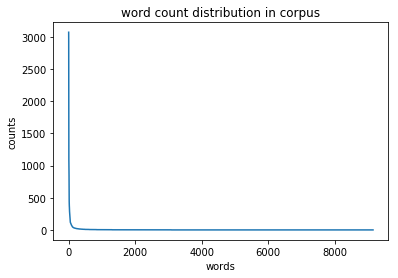

In [12]:
counts = np.sum(X, axis=0).tolist()
counts = sorted(counts[0], reverse=True)
plt.plot(np.arange(len(counts)), counts)
plt.title("word count distribution in corpus")
plt.ylabel("counts")
plt.xlabel("words")
acc = []

## Compute Baseline Embedding (BoW)

<a href="https://www.codecogs.com/eqnedit.php?latex=v_s&space;=&space;\frac{1}{\left&space;\|&space;S&space;\right&space;\|}&space;\sum_{w&space;\in&space;S}&space;v_w" target="_blank"><img src="https://latex.codecogs.com/gif.latex?v_s&space;=&space;\frac{1}{\left&space;\|&space;S&space;\right&space;\|}&space;\sum_{w&space;\in&space;S}&space;v_w" title="v_s = \frac{1}{\left \| S \right \|} \sum_{w \in S} v_w" /></a>

In [13]:
# VOCAB_SIZE = 3000
VOCAB_SIZE = X.shape[1]
# counter = CountVectorizer(strip_accents="unicode", max_features=VOCAB_SIZE)
# counter = CountVectorizer(max_features=VOCAB_SIZE, tokenizer=ut.tokenizer)

caption_texts = corpus
Xc = counter.fit_transform(caption_texts).todense().astype("float")
print(Xc.shape)

(3413, 9153)


In [15]:
sent_lens = np.sum(Xc, axis=1).astype("float")
sent_lens[sent_lens == 0] = 1e-14
print(sent_lens.shape)

(3413, 1)


In [ ]:
E = np.zeros((VOCAB_SIZE, 1024))
for word in counter.vocabulary_.keys():
    try:
        i = counter.vocabulary_[word]
#         E[i] = embedding_matrix[stoi[word]] 
        E[i] = e.sents2elmo([[word]])[0].reshape(-1);
    except KeyError:
        pass
    
E[counter.vocabulary_['muchas']] = np.randn(1024)
E[counter.vocabulary_['gracias']] = np.randn(1024)
print(E.shape)

In [42]:
Xb = np.divide(np.dot(Xc, E), sent_lens)
print(Xb.shape)

(3413, 1024)


In [43]:
tst_labels = np.load(CLAS_PATH/'tmp/tst_labels.npy').flatten()
Xtrain, Xval, Xtest = Xb[0:(len(tweets_trn[:,1])+len(tweets_val[:,1]))], Xb[len(tweets_trn[:,1]):(len(tweets_trn[:,1])+len(tweets_val[:,1]))], Xb[(len(tweets_trn[:,1])+len(tweets_val[:,1])):]
ytrain, yval, ytest = np.concatenate([tweets_trn[:,0], tweets_val[:,0]]).astype('int'), np.array(tweets_val[:,0]).astype('int'), tst_labels.astype('int')
print(Xtrain.shape, ytrain.shape, Xval.shape, yval.shape, Xtest.shape, ytest.shape)

(1514, 1024) (1514,) (506, 1024) (506,) (1899, 1024) (1899,)


In [44]:
def cross_val(Xtrain, ytrain, clf):
    best_clf = None
    best_score = 0.0
    num_folds = 0
    cv_scores = []
    kfold = KFold(n_splits=10)
    for train, val in kfold.split(Xtrain):
        Xctrain, Xctest, yctrain, yctest = Xtrain[train], Xtrain[val], ytrain[train], ytrain[val]
#         clf.fit(np.concatenate((Xctrain, Xctest), axis=0), np.concatenate((yctrain, yctest), axis=0))
        clf.fit(Xctrain, yctrain)
        # clf.fit(Xctrain, yctrain)
        ytest_ = clf.predict(Xctest)
        score = f1_score(yctest, ytest_, average='macro')
#         score = clf.score(Xctest, yctest)
        if score > best_score:
            best_score = score
            best_clf = clf
        print("fold {:d}, score: {:.3f}".format(num_folds, score))
        cv_scores.append(score)
        num_folds += 1
    return best_clf, cv_scores

def test_eval(Xtest, ytest, clf):
    print("===")
    print("Test set results")
    ytest_ = clf.predict(Xtest)
    accuracy = accuracy_score(ytest, ytest_)
    acc.append(accuracy)
    print("Accuracy: {:.3f}".format(accuracy))
    print("---")
    print("F1-M: {:.3f}".format(f1_score(ytest, ytest_, average='macro')))
    print("---")
    print("Confusion Matrix")
    cm = confusion_matrix(ytest, ytest_)
    print(cm)
    print("---")
    print("Classification Report")
    cr = classification_report(ytest, ytest_)
    print(cr)

In [45]:
from sklearn.naive_bayes import GaussianNB
from keras.utils import to_categorical

clf = GaussianNB()
best_clf, scores_nb = cross_val(Xtrain, ytrain, clf)
# clf.fit(Xtrain, ytrain.astype('int'))
test_eval(Xtest, ytest, best_clf)

fold 0, score: 0.418
fold 1, score: 0.415
fold 2, score: 0.401
fold 3, score: 0.400
fold 4, score: 0.372
fold 5, score: 0.403
fold 6, score: 0.360
fold 7, score: 0.363
fold 8, score: 0.382
fold 9, score: 0.393
===
Test set results
Accuracy: 0.434
---
F1-M: 0.376
---
Confusion Matrix
[[423  75 118 151]
 [179 229  67 167]
 [ 93  33  34  56]
 [ 64  35  36 139]]
---
Classification Report
              precision    recall  f1-score   support

           0       0.56      0.55      0.55       767
           1       0.62      0.36      0.45       642
           2       0.13      0.16      0.14       216
           3       0.27      0.51      0.35       274

   micro avg       0.43      0.43      0.43      1899
   macro avg       0.39      0.39      0.38      1899
weighted avg       0.49      0.43      0.44      1899



In [47]:
from sklearn.svm import SVC

clf = SVC(kernel='linear', C=0.8)
best_clf, scores_svc = cross_val(Xtrain, ytrain, clf)
test_eval(Xtest, ytest, best_clf)

fold 0, score: 0.406
fold 1, score: 0.396
fold 2, score: 0.404
fold 3, score: 0.392
fold 4, score: 0.437
fold 5, score: 0.383
fold 6, score: 0.424
fold 7, score: 0.346
fold 8, score: 0.268
fold 9, score: 0.434
===
Test set results
Accuracy: 0.511
---
F1-M: 0.396
---
Confusion Matrix
[[513 119  88  47]
 [191 376  38  37]
 [104  55  34  23]
 [118  84  25  47]]
---
Classification Report
              precision    recall  f1-score   support

           0       0.55      0.67      0.61       767
           1       0.59      0.59      0.59       642
           2       0.18      0.16      0.17       216
           3       0.31      0.17      0.22       274

   micro avg       0.51      0.51      0.51      1899
   macro avg       0.41      0.40      0.40      1899
weighted avg       0.49      0.51      0.49      1899



In [48]:
test_values = clf.predict(Xtest)

In [49]:
from sklearn.metrics import f1_score

f1_score(clf.predict(Xval), np.array(yval), average='macro')

0.7369758560388109

In [50]:
def getLabel(num):
    if num == 0:
        return 'N'
    elif num == 1:
        return 'P'
    elif num == 2:
        return 'NEU'
    elif num == 3:
        return 'NONE'
    
import xml.etree.ElementTree as ET

def putTestValue(xmlFIle, out):
    tree = ET.parse(xmlFIle)
    root = tree.getroot()

    tweets = []
    file = open(out,"w") 
    print(len(test_values))
    for i,tweet in enumerate(root.iter('tweet')): 
        #print(i)
        val = getLabel(test_values[i])
        ID = tweet.find('tweetid').text
        file.write(ID + "\t" + val + "\n")
    file.close() 

In [ ]:
putTestValue("../database/TASS/TASS2018/task1-Test.xml", "output2018-2.txt")

## Smooth Inverse Frequency (SIF) Embedding

<a href="https://www.codecogs.com/eqnedit.php?latex=v_s&space;=&space;\frac{1}{\left&space;\|&space;S&space;\right&space;\|}&space;\sum_{w&space;\in&space;S}&space;\frac{\alpha}{\alpha&space;&plus;&space;p_w}&space;v_w" target="_blank"><img src="https://latex.codecogs.com/gif.latex?v_s&space;=&space;\frac{1}{\left&space;\|&space;S&space;\right&space;\|}&space;\sum_{w&space;\in&space;S}&space;\frac{\alpha}{\alpha&space;&plus;&space;p_w}&space;v_w" title="v_s = \frac{1}{\left \| S \right \|} \sum_{w \in S} \frac{\alpha}{\alpha + p_w} v_w" /></a>

In [52]:
# from paper
ALPHA = 1e-3

In [53]:
# # compute word probabilities from corpus
freqs = np.sum(Xc, axis=0).astype("float")
probs = freqs / np.sum(freqs)

In [54]:
# compute multiplier ALPHA / (ALPHA + probs)
coeff = ALPHA / (ALPHA + probs)

In [55]:
# compute weighted counts
Xw = np.multiply(Xc, coeff)

In [56]:
# convert to SIF embeddings
Xs = np.divide(np.dot(Xw, E), sent_lens)

print(Xc.shape, coeff.shape, Xs.shape, E.shape)

(3413, 9153) (1, 9153) (3413, 1024) (9153, 1024)


In [57]:
# compute 1st principal component
svd = TruncatedSVD(n_components=1, n_iter=20, random_state=0)
svd.fit(Xs)
pc = svd.components_
print(pc.shape, svd.explained_variance_ratio_)

(1, 1024) [0.094402]


In [58]:
# remove it from the weighted counts
Xr = Xs - Xs.dot(pc.T).dot(pc)
print(Xr.shape)

(3413, 1024)


In [59]:
Xtrain, Xval, Xtest = Xb[0:(len(tweets_trn[:,1])+len(tweets_val[:,1]))], Xb[len(tweets_trn[:,1]):(len(tweets_trn[:,1])+len(tweets_val[:,1]))], Xb[(len(tweets_trn[:,1])+len(tweets_val[:,1])):]
ytrain, yval, ytest = np.concatenate([tweets_trn[:,0], tweets_val[:,0]]).astype('int'), np.array(tweets_val[:,0]).astype('int'), tst_labels.astype('int')
print(Xtrain.shape, ytrain.shape, Xval.shape, yval.shape, Xtest.shape, ytest.shape)

(1514, 1024) (1514,) (506, 1024) (506,) (1899, 1024) (1899,)


In [60]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
best_clf, scores_nb = cross_val(Xtrain, ytrain, clf)
test_eval(Xtest, ytest, best_clf)

fold 0, score: 0.418
fold 1, score: 0.415
fold 2, score: 0.401
fold 3, score: 0.400
fold 4, score: 0.372
fold 5, score: 0.403
fold 6, score: 0.360
fold 7, score: 0.363
fold 8, score: 0.382
fold 9, score: 0.393
===
Test set results
Accuracy: 0.434
---
F1-M: 0.376
---
Confusion Matrix
[[423  75 118 151]
 [179 229  67 167]
 [ 93  33  34  56]
 [ 64  35  36 139]]
---
Classification Report
              precision    recall  f1-score   support

           0       0.56      0.55      0.55       767
           1       0.62      0.36      0.45       642
           2       0.13      0.16      0.14       216
           3       0.27      0.51      0.35       274

   micro avg       0.43      0.43      0.43      1899
   macro avg       0.39      0.39      0.38      1899
weighted avg       0.49      0.43      0.44      1899



In [61]:
from sklearn.svm import SVC

clf = SVC(kernel='linear', C=0.8, gamma='scale')
best_clf, scores_svc = cross_val(Xtrain, ytrain, clf)
test_eval(Xtest, ytest, best_clf)

fold 0, score: 0.406
fold 1, score: 0.396
fold 2, score: 0.404
fold 3, score: 0.392
fold 4, score: 0.437
fold 5, score: 0.383
fold 6, score: 0.424
fold 7, score: 0.346
fold 8, score: 0.268
fold 9, score: 0.434
===
Test set results
Accuracy: 0.511
---
F1-M: 0.396
---
Confusion Matrix
[[513 119  88  47]
 [191 376  38  37]
 [104  55  34  23]
 [118  84  25  47]]
---
Classification Report
              precision    recall  f1-score   support

           0       0.55      0.67      0.61       767
           1       0.59      0.59      0.59       642
           2       0.18      0.16      0.17       216
           3       0.31      0.17      0.22       274

   micro avg       0.51      0.51      0.51      1899
   macro avg       0.41      0.40      0.40      1899
weighted avg       0.49      0.51      0.49      1899



In [62]:
clf = SVC(kernel='linear', C=11, gamma='scale')
clf.fit(Xtrain, ytrain)

SVC(C=11, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [63]:
test_eval(Xtest, ytest, clf)

===
Test set results
Accuracy: 0.491
---
F1-M: 0.396
---
Confusion Matrix
[[477 146  90  54]
 [182 358  54  48]
 [104  57  37  18]
 [ 98  84  31  61]]
---
Classification Report
              precision    recall  f1-score   support

           0       0.55      0.62      0.59       767
           1       0.56      0.56      0.56       642
           2       0.17      0.17      0.17       216
           3       0.34      0.22      0.27       274

   micro avg       0.49      0.49      0.49      1899
   macro avg       0.41      0.39      0.40      1899
weighted avg       0.48      0.49      0.48      1899



In [ ]:
test_values = clf.predict(Xtest)

In [ ]:
putTestValue("../database/TASS/TASS2018/task1-Test.xml", "output2018-3.txt")

In [ ]:
xlabels = ["2.0k", "2.5k", "3.0k", "3.5k", "4.0k", "all"]
# xs = [10000, 20000, 30000, 40000, 50000, 64170, 64450]
# we have changed the actual numbers to evenly space the points
xs = [2000, 2500, 3000, 3500, 4000, 4344]

ylabels = ["BoW/NB", "BoW/SVM", "SIF/NB", "SIF/SVM"]
ys = np.array(
        [[0.627, 0.635, 0.635, 0.632, 0.635, 0.648],
         [0.733, 0.744, 0.755, 0.747, 0.755, 0.747],
         [0.587, 0.600, 0.605, 0.635, 0.648, 0.648],
         [0.728, 0.725, 0.736, 0.731, 0.736, 0.741]])
ids_nb = [i for i, y in enumerate(ylabels) if y.endswith("/NB")]
labels_nb = [y.split("/")[0] for y in ylabels if y.endswith("/NB")]
ids_svm = [i for i, y in enumerate(ylabels) if y.endswith("/SVM")]
labels_svm = [y.split("/")[0] for y in ylabels if y.endswith("/SVM")]
colors = ["r", "g", "b"]

plt.figure(figsize=(10, 5))

plt.subplot(121)
curr_row = 0
for row in ids_nb:
    plt.plot(xs, ys[row, :], marker="o", 
             color=colors[curr_row], label=labels_nb[curr_row])
    curr_row += 1
plt.xticks(xs, xlabels)
plt.title("Naive Bayes (TASS 2017)")
plt.ylabel("classification accuracy")
plt.xlabel("vocab size")
plt.legend(loc="best")

plt.subplot(122)
curr_row = 0
for row in ids_svm:
    plt.plot(xs, ys[row, :], marker="o", 
             color=colors[curr_row], label=labels_svm[curr_row])
    curr_row += 1
plt.xticks(xs, xlabels)
plt.title("Support Vector Machine C=0.8 (TASS 2017)")
plt.ylabel("classification accuracy")
plt.xlabel("vocab size")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [ ]:
xlabels = ["1.0k", "1.5k", "2.0k", "2.5k", "3.0k", "all"]
# xs = [10000, 20000, 30000, 40000, 50000, 64170, 64450]
# we have changed the actual numbers to evenly space the points
xs = [1000, 1500, 2000, 2500, 3000, 3142]

ylabels = ["BoW/NB", "BoW/SVM", "SIF/NB", "SIF/SVM"]
ys = np.array(
        [[0.537, 0.552, 0.562, 0.557, 0.562, 0.562],
         [0.686, 0.726, 0.726, 0.706, 0.711, 0.736],
         [0.517, 0.532, 0.552, 0.562, 0.572, 0.592],
         [0.696, 0.686, 0.686, 0.701, 0.691, 0.716]])
ids_nb = [i for i, y in enumerate(ylabels) if y.endswith("/NB")]
labels_nb = [y.split("/")[0] for y in ylabels if y.endswith("/NB")]
ids_svm = [i for i, y in enumerate(ylabels) if y.endswith("/SVM")]
labels_svm = [y.split("/")[0] for y in ylabels if y.endswith("/SVM")]
colors = ["r", "g", "b"]

plt.figure(figsize=(10, 5))

plt.subplot(121)
curr_row = 0
for row in ids_nb:
    plt.plot(xs, ys[row, :], marker="o", 
             color=colors[curr_row], label=labels_nb[curr_row])
    curr_row += 1
plt.xticks(xs, xlabels)
plt.title("Naive Bayes (TASS 2018)")
plt.ylabel("classification accuracy")
plt.xlabel("vocab size")
plt.legend(loc="best")

plt.subplot(122)
curr_row = 0
for row in ids_svm:
    plt.plot(xs, ys[row, :], marker="o", 
             color=colors[curr_row], label=labels_svm[curr_row])
    curr_row += 1
plt.xticks(xs, xlabels)
plt.title("Support Vector Machine C=10 (TASS 2018)")
plt.ylabel("classification accuracy")
plt.xlabel("vocab size")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [ ]:
!pip install tflearn
import pandas as pd
import numpy as np
import tensorflow as tf
import tflearn
from tflearn.data_utils import to_categorical

In [ ]:
# Network building
def build_model():
    # This resets all parameters and variables, leave this here
    tf.reset_default_graph()
    
    # Inputs
    net = tflearn.input_data([None, 45])

    # Hidden layer(s)
    net = tflearn.fully_connected(net, 300, activation='ReLU')
    #net = tflearn.dropout(net, keep_prob=0.2)
    net = tflearn.fully_connected(net, 150, activation='ReLU')
    net = tflearn.fully_connected(net, 50, activation='ReLU')
    net = tflearn.fully_connected(net, 10, activation='ReLU')

    # Output layer
    net = tflearn.fully_connected(net, 4, activation='sigmoid')
    net = tflearn.regression(net, optimizer='sgd', 
                             learning_rate=0.5, 
                             loss='categorical_crossentropy')
    
    model = tflearn.DNN(net)
    return model

In [ ]:
model = build_model()

In [ ]:
sequences = []
for tweet in corpus:
    sentence = []
    for word in ut.tokenizer(tweet):
        try:
            i = counter.vocabulary_[word]
            sentence.append(i)
        except KeyError:
            pass
        
    sequences.append(sentence)

In [ ]:
len(sequences)

In [ ]:
from keras.preprocessing.sequence import pad_sequences
x_train_seq = pad_sequences(sequences[:len(Xtrain)], maxlen=45)
x_test_seq  = pad_sequences(sequences[-len(Xtest):], maxlen=45)
print('Shape of data train tensor:', x_train_seq.shape)
print('Shape of data val  tensor:', x_test_seq.shape)
print(len(ytrain))

In [ ]:
# model.fit(x_train_seq, ytrain, validation_set=0.2, show_metric=True, batch_size=64, n_epoch=150)
model.fit(x_train_seq, to_categorical(ytrain, 4), validation_set=0.2, show_metric=True, batch_size=64, n_epoch=150)

In [ ]:
from numpy import argmax
def test_eval(Xtest, ytest, clf):
    print("===")
    print("Test set results")
    ytest_ = argmax(clf.predict(Xtest), axis=1)
    accuracy = accuracy_score(ytest, ytest_)
    acc.append(accuracy)
    print("Accuracy: {:.3f}".format(accuracy))
    print("---")
    print("Confusion Matrix")
    cm = confusion_matrix(ytest, ytest_)
    print(cm)
    print("---")
    print("Classification Report")
    cr = classification_report(ytest, ytest_)
    print(cr)

In [ ]:
test_eval(x_test_seq, ytest, model)

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
from utils import data
from models.gru_svm.gru_svm import GruSvm

# hyper-parameters for the model
BATCH_SIZE = 256
CELL_SIZE = 256
DROPOUT_P_KEEP = 0.85
HM_EPOCHS = 10
LEARNING_RATE = 1e-5
N_CLASSES = 2
SEQUENCE_LENGTH = 21
SVM_C = 0.5

In [ ]:
def main(argv):

    if argv.operation == 'train':
        # get the train data
        # features: train_data[0], labels: train_data[1]
        train_features, train_labels = data.load_data(dataset=argv.train_dataset)

        # get the validation data
        # features: validation_data[0], labels: validation_data[1]
        validation_features, validation_labels = data.load_data(dataset=argv.validation_dataset)

        # get the size of the dataset for slicing
        train_size = train_features.shape[0]
        validation_size = validation_features.shape[0]

        # slice the dataset to be exact as per the batch size
        # e.g. train_size = 1898322, batch_size = 256
        # [:1898322-(1898322%256)] = [:1898240]
        # 1898322 // 256 = 7415; 7415 * 256 = 1898240
        train_features = train_features[:train_size-(train_size % BATCH_SIZE)]
        train_labels = train_labels[:train_size-(train_size % BATCH_SIZE)]

        # modify the size of the dataset to be passed on model.train()
        train_size = train_features.shape[0]

        # slice the dataset to be exact as per the batch size
        validation_features = validation_features[:validation_size-(validation_size % BATCH_SIZE)]
        validation_labels = validation_labels[:validation_size-(validation_size % BATCH_SIZE)]

        # modify the size of the dataset to be passed on model.train()
        validation_size = validation_features.shape[0]

        # instantiate the model
        model = GruSvm(alpha=LEARNING_RATE, batch_size=BATCH_SIZE, cell_size=CELL_SIZE, dropout_rate=DROPOUT_P_KEEP,
                       num_classes=N_CLASSES, sequence_length=SEQUENCE_LENGTH, svm_c=SVM_C)

        # train the model
        model.train(checkpoint_path=argv.checkpoint_path, log_path=argv.log_path, model_name=argv.model_name,
                    epochs=HM_EPOCHS, train_data=[train_features, train_labels], train_size=train_size,
                    validation_data=[validation_features, validation_labels], validation_size=validation_size,
                    result_path=argv.result_path)
    elif argv.operation == 'test':
        test_features, test_labels = data.load_data(dataset=argv.validation_dataset)

        test_size = test_features.shape[0]

        test_features = test_features[:test_size-(test_size % BATCH_SIZE)]
        test_labels = test_labels[:test_size-(test_size % BATCH_SIZE)]

        test_size = test_features.shape[0]

        GruSvm.predict(batch_size=BATCH_SIZE, cell_size=CELL_SIZE, dropout_rate=DROPOUT_P_KEEP, num_classes=N_CLASSES,
                       test_data=[test_features, test_labels], test_size=test_size,
checkpoint_path=argv.checkpoint_path, result_path=argv.result_path)